# Final Project

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from datetime import datetime


#SK-learn libraries for setup
from sklearn.model_selection import train_test_split

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

#SK-learn libraries for transformation and pre-processing
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer



# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer


In [6]:
#Read data
os.chdir("/Users/nwchen24/Desktop/UC_Berkeley/machine_learning/final_project_github_repo/w207_kaggleproject/data/")
#os.chdir("C:/Users/nchen/Desktop/Nick/UC_Berkeley/machine_learning/final_project_github_repo/w207_kaggleproject/data")

#training data
train_data_full = pd.read_csv('train.csv')
train_data_full.head()

#testing data
test_data = pd.read_csv('test.csv')

In [7]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

## Prep

In [8]:
#Create a program age variable
#Do this before we do the train test split because the beginning of the program is a constant, so we don't
#have to worry about 'contaminating' any of our data by applying the same transformation to the entire dataset

#Convert to datetime object
train_data_full['datetime'] = train_data_full['datetime'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
test_data['datetime'] = test_data['datetime'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

#Initialized program beginning
prog_beginning = '2011-01-01 00:00:00'

prog_beginning_conv = datetime.strptime(prog_beginning, '%Y-%m-%d %H:%M:%S')

#Create a program age variable
train_data_full['prog_age'] = train_data_full['datetime'] - prog_beginning_conv
test_data['prog_age'] = test_data['datetime'] - prog_beginning_conv


#convert the time delta to float of days
train_data_full['prog_age'] = train_data_full['prog_age'].dt.total_seconds() / (24 * 60 * 60)
test_data['prog_age'] = test_data['prog_age'].dt.total_seconds() / (24 * 60 * 60)


#create an hour variable in both the training and development data
train_data_full['hour'] = train_data_full.datetime.apply(lambda x : x.hour)
test_data['hour'] = test_data.datetime.apply(lambda x : x.hour)

In [9]:
#Split into train and development
train_data, dev_data = train_test_split(train_data_full, random_state = 0)

In [10]:
print test_data.datetime.dtype
print train_data_full.datetime.dtype
test_data.tail()

datetime64[ns]
datetime64[ns]


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,prog_age,hour
6488,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014,730.791667,19
6489,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014,730.833333,20
6490,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014,730.875000,21
6491,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981,730.916667,22
6492,2012-12-31 23:00:00,1,0,1,1,10.66,13.635,65,8.9981,730.958333,23


In [11]:
#Add a string desctriptor for weather
weather_values = [1,2,3,4]
weather_descriptions = ['Nice Weather', 'OK Weather', 'Poor Weather', 'Bad Weather']
weather_dict_df = pd.DataFrame({'weather' : weather_values, 'weather_descriptions': weather_descriptions})

weather_dict_df
train_data = pd.merge(train_data, weather_dict_df, how = 'left')

#Add a string descriptor for season
season_values = [1,2,3,4]
season_str = ['Spring', 'Summer', 'Fall', 'Winter']
season_dict_df = pd.DataFrame({'season' : season_values, 'season_str': season_str})

train_data = pd.merge(train_data, season_dict_df, how = 'left')

train_data.head()

train_data.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,prog_age,hour
count,8164.000000,8164.000000,8164.000000,8164.00000,8164.000000,8164.000000,8164.000000,8164.000000,8164.000000,8164.000000,8164.000000,8164.000000,8164.000000
mean,2.496570,0.029030,0.679936,1.41389,20.137509,23.551758,61.836722,12.832602,35.762371,154.923199,190.685571,359.423643,11.554998
std,1.118645,0.167901,0.466529,0.63025,7.776977,8.463277,19.239196,8.262360,49.826465,151.318558,181.191213,211.072559,6.929567
min,1.000000,0.000000,0.000000,1.00000,0.820000,2.275000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,1.00000,13.940000,16.665000,47.000000,7.001500,4.000000,36.000000,43.000000,181.072917,6.000000
50%,2.000000,0.000000,1.000000,1.00000,20.500000,24.240000,62.000000,12.998000,16.000000,116.000000,142.000000,365.854167,12.000000
75%,3.000000,0.000000,1.000000,2.00000,26.240000,31.060000,77.000000,16.997900,48.000000,223.000000,284.000000,535.635417,18.000000
max,4.000000,1.000000,1.000000,4.00000,41.000000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000,718.916667,23.000000


In [13]:
#Helper function to calculate root mean squared error
def get_RMSE(actual_values, predicted_values):
    n = len(actual_values)
    RMSE = np.sqrt(np.sum(((np.log(predicted_values + 1) - np.log(actual_values + 1)) ** 2) / n))
    return RMSE

    

## Feature Engineering / Preprocessing

In [14]:
#Create lists of categorical and numeric predictors
categorical_predictors = ['season', 'holiday', 'workingday', 'hour']
numerical_predictors = ['temp', 'atemp', 'humidity', 'windspeed', 'prog_age']

In [15]:
#Categorical variable imputer
class CategoricalImputer(BaseEstimator, TransformerMixin):
    
    def __init__(self, cols):
        self.cols = cols
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        transformed_df = X
        for col in self.cols:
            transformed_df.loc[:, col] = transformed_df.loc[:, col].astype(str)
        return transformed_df
       

In [16]:
#One-hot / hashing for categorical features
from sklearn.feature_extraction import FeatureHasher, DictVectorizer

class MyVectorizer(BaseEstimator, TransformerMixin):
    """
    Vectorize a set of categorical variables
    """
    
    def __init__(self, cols, hashing=None):
        """
        args:
            cols: a list of column names of the categorical variables
            hashing: 
                If None, then vectorization is a simple one-hot-encoding.
                If an integer, then hashing is the number of features in the output.
        """
        self.cols = cols
        self.hashing = hashing
        
    def fit(self, X, y=None):      
        #define the data
        data = X[self.cols]
        
        #select a vectorizer based on the hashing argument
        if self.hashing == None:
            self.myvec = DictVectorizer(sparse=False)
        else:
            self.myvec = FeatureHasher(n_features=self.hashing)
        
        #fit the vectorizer chosen based on columns specified
        self.myvec.fit(X[self.cols].to_dict(orient='records'))
        return self
            
    def transform(self, X):
        # Vectorize Input
        if self.hashing is None:
            return pd.DataFrame(
                self.myvec.transform(X[self.cols].to_dict(orient='records')),
                columns = self.myvec.feature_names_
            )
        else:
            return pd.DataFrame(
                self.myvec.transform(X[self.cols].to_dict(orient='records')).toarray()
            )
   

In [17]:
#Numerical variable imputer
class MyNumericImputer(BaseEstimator, TransformerMixin):
    
    def __init__(self, cols, strategy = 'mean'):
        self.cols = cols
        self.strategy = strategy

    def fit(self, X, y=None):       
        self.imputer = Imputer(strategy = self.strategy)
        self.imputer.fit(X[self.cols])
        return self
    
    def transform(self, X):
        return pd.DataFrame(self.imputer.transform(X[self.cols]), columns = self.cols)
        #return self.imputer.transform(X[self.cols])


In [18]:
#Numeical variable scaler
class MyScaler(BaseEstimator, TransformerMixin):
    
    def __init__(self, cols):
        self.cols = cols
        
    def fit(self, X, y=None):
        self.scaler = StandardScaler()
        self.scaler.fit(X[self.cols])
        return self
    
    def transform(self, X):
        return pd.DataFrame(self.scaler.transform(X[self.cols]), columns = self.cols)

In [19]:
#Categorical pipeline

#instantiate imputer and vectorizer for categorical pipe
imp_for_pipe = CategoricalImputer(categorical_predictors)
vect_for_pipe = MyVectorizer(cols = categorical_predictors, hashing = None)



#construct pipeline
categorical_pipe = Pipeline([
        ('to_string', imp_for_pipe),
        ('vectorize', vect_for_pipe)
    ])

In [21]:
#Numerical variables pipeline

#instantiate imputer for pipeline
mynumimp = MyNumericImputer(cols = numerical_predictors, strategy = 'mean')
#instantiate scaler for pipeline
scaler = MyScaler(cols = numerical_predictors)

#construct pipeline
numerical_pipe = Pipeline([
        ('impute', mynumimp),
        ('scale', scaler)
    ])

In [22]:
#transform both the categorical and numeric features using FeatureUnion
fu = FeatureUnion([
        ('numerical', numerical_pipe),
        ('categorical', categorical_pipe)
    ])


#Training data
X_train_transformed = fu.fit_transform(train_data)
X_train_transformed_df = pd.DataFrame(X_train_transformed)

#Development data
X_dev_transformed = fu.transform(dev_data)
X_dev_transformed_df = pd.DataFrame(X_dev_transformed)

#test data
X_test_transformed = fu.transform(test_data)
X_test_transformed_df = pd.DataFrame(X_test_transformed)

#X_dev_transformed_df.head()
X_train_transformed_df.head()
#X_dev_transformed_df.shape
#dev_data.shape
#dev_data['prog_age']
#dev_data.prog_age
#train_data['prog_age']

/Users/nwchen24/anaconda/envs/Machine_learning_python2/lib/python2.7/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,36
0,-0.691508,-0.723967,1.619880,-0.464121,1.654910,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1,1.101073,1.066229,0.164428,-1.553235,-0.902227,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.257505,0.260936,-1.291023,1.351609,0.646111,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,-0.164278,-0.097694,1.671860,0.020020,-0.095188,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,-0.586062,-0.455733,-0.823199,1.594085,-1.199141,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


## Model  

Earlier versions contain random forest and gradient boosted regressor models

### Scoring Function for GridsearchCV

In [23]:
RMSE_scorer = make_scorer(get_RMSE, greater_is_better = False)

### Adaboost - Split into Late Night and Not

Helper function to split data into late night / day time  
@Keri - Can adjust start and end time of the day / night in the cell below

In [100]:
def late_day_split(data_df, beg_late_night = 16, end_late_night = 5):
    late_night_df = data_df.loc[(data_df.hour <= end_late_night) | (data_df.hour >= beg_late_night), :]
    day_df = data_df.loc[(data_df.hour > end_late_night) & (data_df.hour < beg_late_night), :]
    return late_night_df, day_df

@Keri - in the cell below, you will want to work on combining the dev and train data back together.  

In a cell above towards the beginning, you can see where I split the training data into train / dev. The original full training data is called 'train_data_full'.  

I think you should just be able to apply my late_day_split function and each of the subsequent steps in the cell below directly to the train_data_full dataset, but I'm not 100% positive. If that is the case, you should just be able to perform parallel steps / transformations on the train_data_full dataset as are performed below on the train_data, dev_data, and test_data individually.

In [95]:
#convert hour back to numerical
train_data.loc[:, 'hour'] = train_data.loc[:, 'hour'].astype(float)
dev_data.loc[:, 'hour'] = dev_data.loc[:, 'hour'].astype(float)
test_data.loc[:, 'hour'] = test_data.loc[:, 'hour'].astype(float)


#first, split into late night and not
late_night_train, day_train = late_day_split(train_data)
late_night_dev, day_dev = late_day_split(dev_data)
late_night_test, day_test = late_day_split(test_data)


#From error analysis below, worst errors for late night seem to be concentrated at high program age. Try taking square root of program age as regularization.
late_night_train['prog_age'] = late_night_train['prog_age'] ** .5
late_night_dev['prog_age'] = late_night_dev['prog_age'] ** .5
late_night_test['prog_age'] = late_night_test['prog_age'] ** .5


#Transform each of the late night and day datasets
late_night_train_transformed = fu.fit_transform(late_night_train)
late_night_train_transformed_df = pd.DataFrame(late_night_train_transformed)

late_night_dev_transformed = fu.transform(late_night_dev)
late_night_dev_transformed_df = pd.DataFrame(late_night_dev_transformed)

late_night_test_transformed = fu.transform(late_night_test)
late_night_test_transformed_df = pd.DataFrame(late_night_test_transformed)


day_train_transformed = fu.fit_transform(day_train)
day_train_transformed_df = pd.DataFrame(day_train_transformed)

day_dev_transformed = fu.transform(day_dev)
day_dev_transformed_df = pd.DataFrame(day_dev_transformed)

day_test_transformed = fu.transform(day_test)
day_test_transformed_df = pd.DataFrame(day_test_transformed)

/Users/nwchen24/anaconda/envs/Machine_learning_python2/lib/python2.7/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/nwchen24/anaconda/envs/Machine_learning_python2/lib/python2.7/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/nwchen24/anaconda/envs/Machine_learning_python2/lib/python2.7/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

### Model

In [98]:
#Next, train a separate classifier for late night and not late night
#instantiate the late and day regressors
dt = DecisionTreeRegressor()
rf = RandomForestRegressor()

#These models perform exceptionally poorly on the dev data for late night
late_regressor = RandomForestRegressor(n_estimators = 200, max_depth = 30)

day_regressor = AdaBoostRegressor(n_estimators = 20, learning_rate = .75, base_estimator = dt)

#fit the classifier for casual rentals
late_regressor.fit(late_night_train_transformed_df, late_night_train['count'])
day_regressor.fit(day_train_transformed_df, day_train['count'])

#predict the training and dev data
preds_late_train = late_regressor.predict(late_night_train_transformed_df)
preds_late_dev = late_regressor.predict(late_night_dev_transformed_df)

preds_day_train = day_regressor.predict(day_train_transformed_df)
preds_day_dev = day_regressor.predict(day_dev_transformed_df)


In [99]:
#Get RMSE for train and dev data
RMSE_train_late = get_RMSE(actual_values = late_night_train['count'], predicted_values = preds_late_train)
print "LATE Train Data Root Mean Squared Error: " + str(RMSE_train_late)

RMSE_dev_late = get_RMSE(actual_values = late_night_dev['count'], predicted_values = preds_late_dev)
print "LATE Dev Data Root Mean Squared Error: " + str(RMSE_dev_late)

print 

RMSE_train_day = get_RMSE(actual_values = day_train['count'], predicted_values = preds_day_train)
print "DAY Train Data Root Mean Squared Error: " + str(RMSE_train_day)

RMSE_dev_day = get_RMSE(actual_values = day_dev['count'], predicted_values = preds_day_dev)
print "DAY Dev Data Root Mean Squared Error: " + str(RMSE_dev_day)

LATE Train Data Root Mean Squared Error: 0.182607006474
LATE Dev Data Root Mean Squared Error: 0.390249560923

DAY Train Data Root Mean Squared Error: 0.0610382948973
DAY Dev Data Root Mean Squared Error: 0.336846353785


### Predict Test Data

Re-combine dev and train to fit final model  

@Keri - You'll want to re-fit the late and day models here on the full re-combined set to predict on the test data


In [101]:
#fit final model

late_regressor.fit(FULL RE-COMBINED TRAIN / DEV DATA - PLACEHOLDER FOR KERI)
day_regressor.fit(FULL RE-COMBINED TRAIN / DEV DATA - PLACEHOLDER FOR KERI)


SyntaxError: invalid syntax (<ipython-input-101-3efc36982a24>, line 3)

In [69]:
#predict
preds_late_test = late_regressor.predict(late_night_test_transformed_df)
preds_day_test = day_regressor.predict(day_test_transformed_df)

#convert test predictions to DataFrame
preds_late_test_df = pd.DataFrame(preds_late_test, columns = ['count'])
preds_day_test_df = pd.DataFrame(preds_day_test, columns = ['count'])

#reset indices so can append date time
late_night_test.reset_index(drop = True, inplace = True)
day_test.reset_index(drop = True, inplace = True)

#add column with datetime
preds_late_test_df['datetime'] = late_night_test['datetime']
preds_day_test_df['datetime'] = day_test['datetime']

#stack
preds_test_df = preds_day_test_df.copy()

preds_test_df = preds_test_df.append(preds_late_test_df)

preds_test_df.shape

(6493, 2)

#### Error Analysis

In [32]:
#Predictions with the largest absolute error
late_dev_errors = preds_late_dev - np.array(late_night_dev['count'])

#merge train errors with training data
dev_errors_df = late_night_dev.copy()

dev_errors_df['raw_error'] = late_dev_errors
dev_errors_df['abs_error'] = abs(dev_errors_df.raw_error)
dev_errors_df['pred_count'] = preds_late_dev

#rank observations by absolute value of error
dev_errors_df['abs_error_rank'] = dev_errors_df.abs_error.rank(ascending = False)
dev_errors_df['hour'] = dev_errors_df.hour.astype(float)


#get the worst ~20% of errors
dev_errors_df = dev_errors_df.sort_values(by = 'abs_error_rank', axis = 0)
dev_errors_df = dev_errors_df.reset_index(drop = True)
worst_errors = dev_errors_df.loc[:300,]
OK_predictions = dev_errors_df.loc[300:,]

worst_errors.describe()

dev_errors_df.head()


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,prog_age,hour,raw_error,abs_error,pred_count,abs_error_rank
0,2012-07-18 17:00:00,3,0,1,1,30.34,34.850,70,16.9979,35,335,370,23.763593,17.0,438.0,438.0,808.0,1.0
1,2012-06-12 18:00:00,2,0,1,1,27.88,31.820,83,12.9980,57,596,653,22.994565,18.0,-328.0,328.0,325.0,2.0
2,2012-10-11 19:00:00,4,0,1,1,18.04,21.970,51,8.9981,81,662,743,25.491011,19.0,-291.0,291.0,452.0,3.0
3,2011-05-11 18:00:00,2,0,1,1,25.42,31.060,50,19.9995,40,234,274,11.434597,18.0,270.0,270.0,544.0,4.0
4,2012-04-08 19:00:00,2,0,0,1,24.60,30.305,23,26.0027,89,187,276,21.535823,19.0,246.0,246.0,522.0,5.0
5,2012-03-16 17:00:00,1,0,1,3,19.68,23.485,82,6.0032,23,235,258,20.993054,17.0,227.0,227.0,485.0,6.0
6,2011-10-11 18:00:00,4,0,1,2,24.60,28.790,78,15.0013,46,493,539,16.844881,18.0,-214.0,214.0,325.0,7.0
7,2012-07-06 18:00:00,3,0,1,1,36.90,40.150,33,16.9979,106,454,560,23.510636,18.0,212.0,212.0,772.0,8.0
8,2012-12-08 18:00:00,4,0,0,1,16.40,20.455,87,7.0015,40,264,304,26.603571,18.0,-197.0,197.0,107.0,9.0
9,2012-11-12 18:00:00,4,1,0,1,21.32,25.000,72,8.9981,65,486,551,26.110343,18.0,-192.0,192.0,359.0,10.0


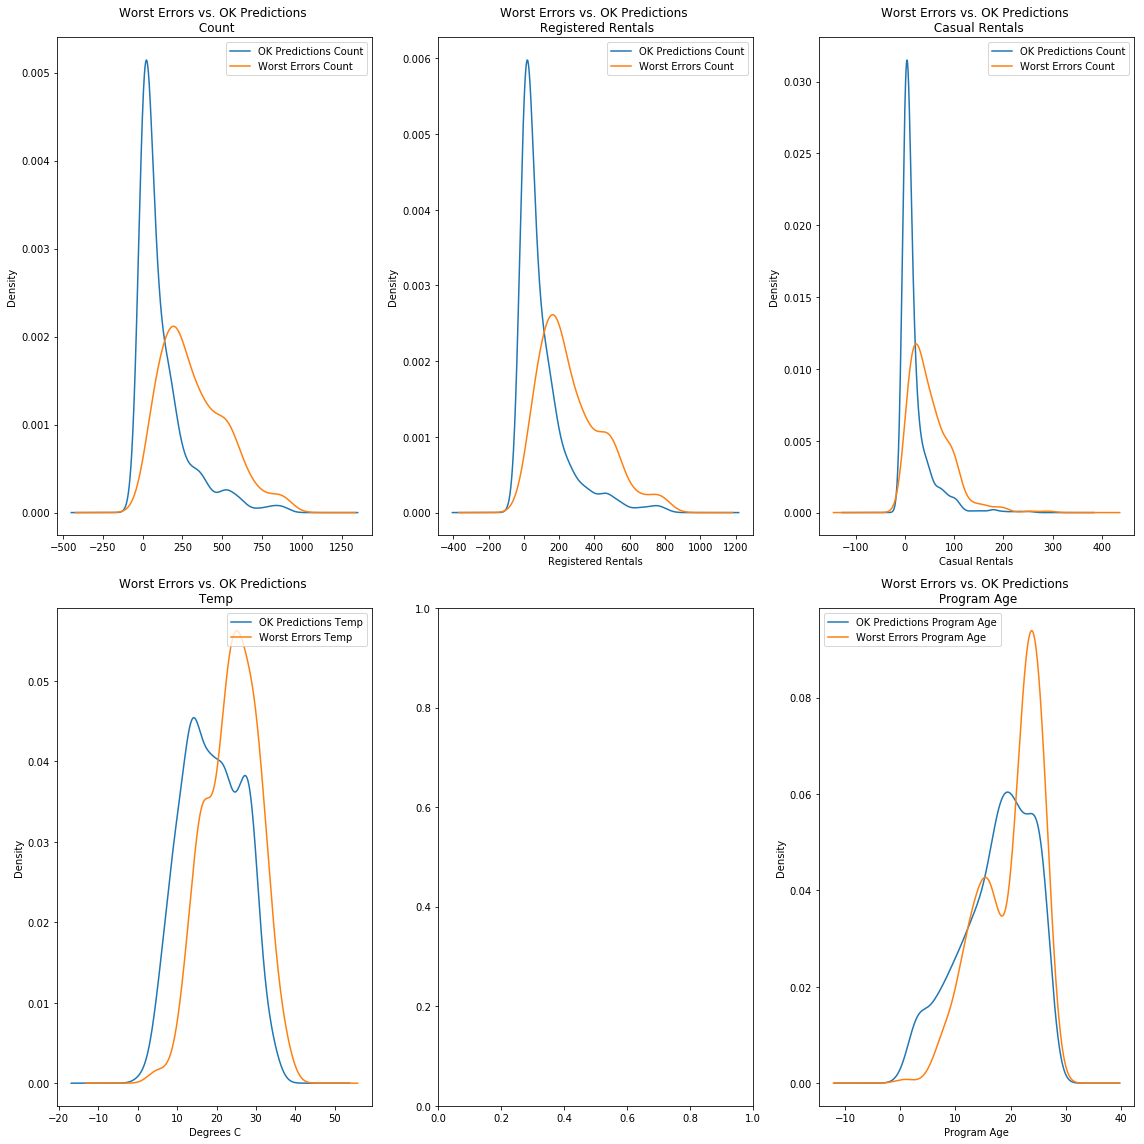

In [33]:
#Look at various features in the worst errors compared to the overall dataset

fig, axes = plt.subplots(nrows=2, ncols=3, sharex=False, sharey=False, figsize = (16,16))


#count
#The model does not seem to do well with high rental days - there is a higher concentration of higher rentals
#in the worst errors than in the other predictions
ax = fig.add_subplot(2,3,1)
plt.subplot(2,3,1)
OK_predictions['count'].plot(kind = 'density', label = 'OK Predictions Count')
worst_errors['count'].plot(kind = 'density', label = 'Worst Errors Count')
plt.legend(loc=1, ncol=1)
plt.title('Worst Errors vs. OK Predictions \n Count')



#registered
#The model does not seem to do well with high rental days - there is a higher concentration of higher rentals
#in the worst errors than in the other predictions
ax = fig.add_subplot(2,3,2)
plt.subplot(2,3,2)
OK_predictions['registered'].plot(kind = 'density', label = 'OK Predictions Count')
worst_errors['registered'].plot(kind = 'density', label = 'Worst Errors Count')
plt.legend(loc=1, ncol=1)
plt.xlabel('Registered Rentals')
plt.title('Worst Errors vs. OK Predictions \n Registered Rentals')


#casual
#The model seems to do pretty well with casual rentals - the distribution of casual rentals
#in the worst predictions and the ok predictions look similar
ax = fig.add_subplot(2,3,3)
plt.subplot(2,3,3)
OK_predictions['casual'].plot(kind = 'density', label = 'OK Predictions Count')
worst_errors['casual'].plot(kind = 'density', label = 'Worst Errors Count')
plt.legend(loc=1, ncol=1)
plt.xlabel('Casual Rentals')
plt.title('Worst Errors vs. OK Predictions \n Casual Rentals')



#Temp
ax = fig.add_subplot(2,3,4)
plt.subplot(2,3,4)
OK_predictions['temp'].plot(kind = 'density', label = 'OK Predictions Temp')
worst_errors['temp'].plot(kind = 'density', label = 'Worst Errors Temp')
plt.legend(loc=1, ncol=1)
plt.xlabel('Degrees C')
plt.title('Worst Errors vs. OK Predictions \n Temp')


#Hour
#ax = fig.add_subplot(2,3,5)
#plt.subplot(2,3,5)
#OK_predictions['hour'].plot(kind = 'density', label = 'OK Predictions Hour')
#worst_errors['hour'].plot(kind = 'density', label = 'Worst Errors Hour')
#plt.legend(loc=1, ncol=1)
#plt.xlabel('Hour')
#plt.title('Worst Errors vs. OK Predictions \n Hour')



#Program age
ax = fig.add_subplot(2,3,6)
plt.subplot(2,3,6)
OK_predictions['prog_age'].plot(kind = 'density', label = 'OK Predictions Program Age')
worst_errors['prog_age'].plot(kind = 'density', label = 'Worst Errors Program Age')
plt.legend(loc=2, ncol=1)
plt.xlabel('Program Age')
plt.title('Worst Errors vs. OK Predictions \n Program Age')


plt.tight_layout()
    
plt.show()




### Export Test Predictions to CSV

In [71]:
#export testing data results

#first change the working directory
os.chdir("/Users/nwchen24/Desktop/UC_Berkeley/machine_learning/final_project_github_repo/w207_kaggleproject/NC_work/Output/")
#os.chdir("C:/Users/nchen/Desktop/Nick/UC_Berkeley/machine_learning/final_project_github_repo/w207_kaggleproject/NC_Work/Output")
#re-order columns
preds_test_df = preds_test_df[['datetime', 'count']]

#export to CSV
preds_test_df.to_csv('NC_submission_3.csv', index = False)

preds_test_df.head()

,datetime,count
0,2011-01-20 06:00:00,33.0
1,2011-01-20 07:00:00,63.0
2,2011-01-20 08:00:00,217.0
3,2011-01-20 09:00:00,118.0
4,2011-01-20 10:00:00,78.0
